# TPCC OU Data Collection

In [20]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import lightgbm as lgb
from datetime import datetime
from pathlib import Path
from scipy import stats

In [21]:
BENCHMARK_NAME = "tpcc"
results_dir = Path.home() / "postgres/cmudb/tscout/results/" / BENCHMARK_NAME
results_dir

PosixPath('/home/gh/postgres/cmudb/tscout/results/tpcc')

In [22]:
experiment_dirs = sorted(list(results_dir.glob("*")))

In [23]:
experiment_dirs

[PosixPath('/home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_01-18-59')]

In [24]:
# taking oldest for now
experiment_dir = experiment_dirs[0]
result_filepaths = list(experiment_dir.glob("**/*.csv"))
print(experiment_dir)

/home/gh/postgres/cmudb/tscout/results/tpcc/2021-11-08_01-18-59


#### Load Data

In [25]:
ou_name_to_df = dict()

for filepath in result_filepaths:
    ou_name = filepath.stem

    if os.stat(filepath).st_size > 0:
        ou_name_to_df[ou_name] = pd.read_csv(filepath)

In [26]:
for (ou_name, ou_df) in ou_name_to_df.items():
    print(f"OU Name: {ou_name}, ou_df shape: {ou_df.shape}")

OU Name: ExecIndexScan, ou_df shape: (1187735, 40)
OU Name: ExecLockRows, ou_df shape: (509463, 35)
OU Name: ExecNestLoop, ou_df shape: (15458, 38)
OU Name: ExecResult, ou_df shape: (95575, 36)
OU Name: ExecLimit, ou_df shape: (26461, 40)
OU Name: ExecSort, ou_df shape: (12661, 41)
OU Name: ExecAgg, ou_df shape: (24824, 59)
OU Name: ExecValuesScan, ou_df shape: (249854, 36)
OU Name: ExecSeqScan, ou_df shape: (50370, 35)
OU Name: ExecModifyTable, ou_df shape: (148010, 43)
OU Name: ExecIndexOnlyScan, ou_df shape: (20210, 40)


# Pre-processing

#### Get IndexScan OU Data

In [27]:
target_ou = 'ExecIndexScan'
df = ou_name_to_df[target_ou]

#### Remove constant columns

In [29]:
cols_to_remove = []
for col in df.columns:
    if df[col].nunique() == 1: 
            cols_to_remove.append(col)

df = df.drop(cols_to_remove, axis=1)
print(f"Dropped zero-variance columns: {cols_to_remove}")
print(f"Num Remaining: {len(df.columns)}, Num Removed {len(cols_to_remove)}")

Dropped zero-variance columns: ['IndexScanState_ss_ps_type', 'IndexScanState_ss_ps_async_capable', 'IndexScanState_ss_ps_scanopsfixed', 'IndexScanState_ss_ps_outeropsfixed', 'IndexScanState_ss_ps_inneropsfixed', 'IndexScanState_ss_ps_resultopsfixed', 'IndexScanState_ss_ps_scanopsset', 'IndexScanState_ss_ps_outeropsset', 'IndexScanState_ss_ps_inneropsset', 'IndexScanState_ss_ps_resultopsset', 'IndexScanState_iss_NumOrderByKeys', 'IndexScanState_iss_PscanLen', 'Plan_type', 'Plan_parallel_aware', 'Plan_async_capable', 'ref_cpu_cycles', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'memory_bytes']
Num Remaining: 20, Num Removed 20


### Remove Start/End Time (since elapsed_us == end_time - start_time)

In [30]:
df = df.drop(['start_time', 'end_time'], axis=1)

### Summarize Features

In [31]:
feat_cols = ['IndexScanState_iss_NumScanKeys',
       'IndexScanState_iss_NumRuntimeKeys',
       'IndexScanState_iss_RuntimeKeysReady', 'IndexScanState_iss_ReachedEnd',
       'Plan_startup_cost', 'Plan_total_cost', 'Plan_plan_rows',
       'Plan_plan_width', 'Plan_parallel_safe', 'Plan_plan_node_id']

features = df[feat_cols]
features.describe()

,IndexScanState_iss_NumScanKeys,IndexScanState_iss_NumRuntimeKeys,IndexScanState_iss_RuntimeKeysReady,IndexScanState_iss_ReachedEnd,Plan_startup_cost,Plan_total_cost,Plan_plan_rows,Plan_plan_width,Plan_parallel_safe,Plan_plan_node_id
count,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06
mean,2.206694e+00,2.150697e+00,9.892720e-01,2.561977e-01,2.740342e-01,8.911876e+00,1.347828e+00,1.280908e+02,2.677365e-01,8.638501e-01
std,7.380210e-01,7.607031e-01,1.030189e-01,4.365325e-01,7.258570e-02,4.832678e+00,2.724602e+00,2.512353e+02,4.427797e-01,5.371313e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.425000e-01,7.303506e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.850000e-01,8.307500e+00,1.000000e+00,1.000000e+01,0.000000e+00,1.000000e+00
50%,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.875000e-01,8.310000e+00,1.000000e+00,1.400000e+01,0.000000e+00,1.000000e+00
75%,3.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.925000e-01,8.312500e+00,1.000000e+00,1.960000e+02,1.000000e+00,1.000000e+00
max,4.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,4.225000e-01,3.113975e+02,1.740000e+02,1.128000e+03,1.000000e+00,3.000000e+00


### Summarize Targets

In [32]:
targets = df[['cpu_cycles', 'instructions', 'cache_references', 'cache_misses', 'disk_bytes_written', 'elapsed_us']]
targets.describe()

,cpu_cycles,instructions,cache_references,cache_misses,disk_bytes_written,elapsed_us
count,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06,1.187735e+06
mean,3.962107e+04,1.113181e+05,2.293575e+03,5.844114e+02,2.694204e-05,8.478098e+00
std,4.284074e+05,1.850090e+06,3.136684e+05,6.529058e+04,2.076228e-02,3.013347e+01
min,3.662000e+03,2.207000e+03,1.670000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.305000e+03,7.275000e+03,5.830000e+02,5.200000e+01,0.000000e+00,1.000000e+00
50%,1.223600e+04,1.942300e+04,1.480000e+03,1.290000e+02,0.000000e+00,2.000000e+00
75%,2.290400e+04,2.552100e+04,2.545000e+03,9.500000e+02,0.000000e+00,5.000000e+00
max,3.471450e+08,1.683286e+09,2.419988e+08,6.530957e+07,1.600000e+01,8.880000e+02


## Show Features

In [33]:
features.head(5)

,IndexScanState_iss_NumScanKeys,IndexScanState_iss_NumRuntimeKeys,IndexScanState_iss_RuntimeKeysReady,IndexScanState_iss_ReachedEnd,Plan_startup_cost,Plan_total_cost,Plan_plan_rows,Plan_plan_width,Plan_parallel_safe,Plan_plan_node_id
0,1,1,1,0,0.145,8.1625,1.0,10,0,1
1,1,1,1,0,0.290,8.3075,1.0,10,0,1
2,1,1,1,0,0.145,8.1625,1.0,10,0,1
3,1,1,1,0,0.290,8.3075,1.0,10,0,1
4,1,1,1,0,0.145,8.1625,1.0,10,0,1


## Show targets

In [34]:
targets.head(5)

,cpu_cycles,instructions,cache_references,cache_misses,disk_bytes_written,elapsed_us
0,14457,10071,2594,3076,0,3
1,13004,14317,2030,868,0,3
2,7258,10414,1949,364,0,1
3,9156,14288,1709,56,0,2
4,6781,10439,1657,93,0,1


In [35]:
def plot_histograms(df): 
    for col_name in df.columns: 
        res = stats.relfreq(df[col_name], numbins=10)
        x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                         res.frequency.size)
        fig = plt.figure(figsize=(6, 2))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x, res.frequency, width=res.binsize)
        ax.set_title(col_name)
        ax.set_xlim([x.min(), x.max()])

#### Visualizations

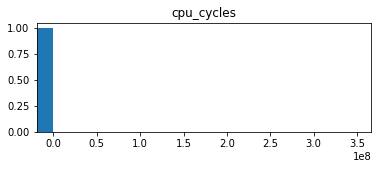

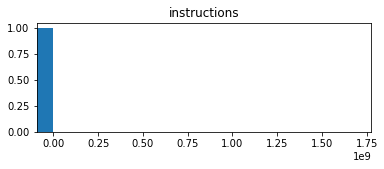

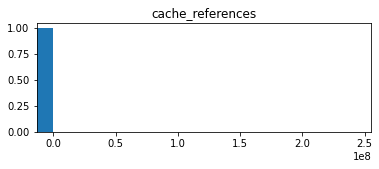

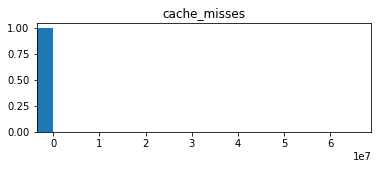

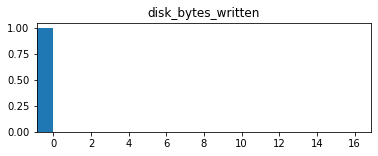

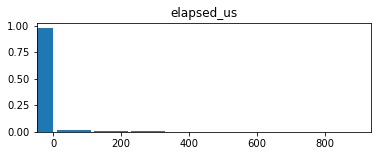

In [36]:
plot_histograms(targets)

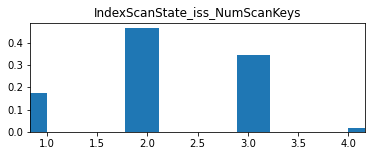

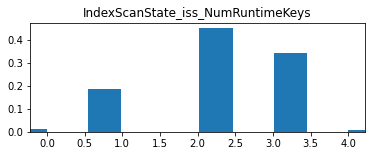

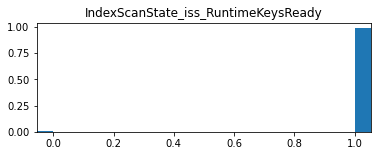

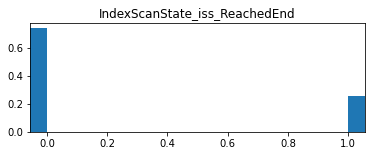

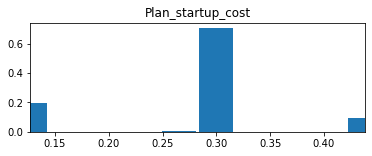

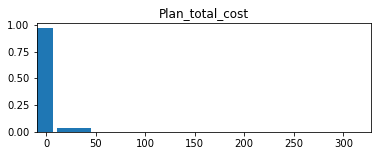

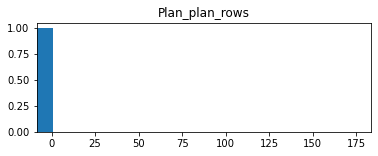

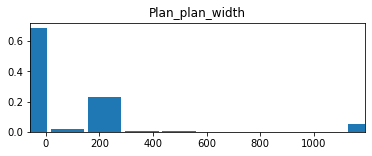

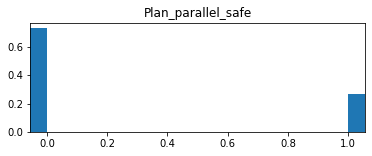

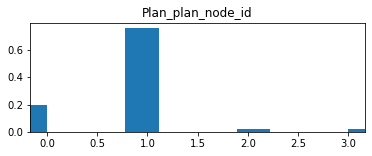

In [37]:
plot_histograms(features)

#### Correlation Heatmap

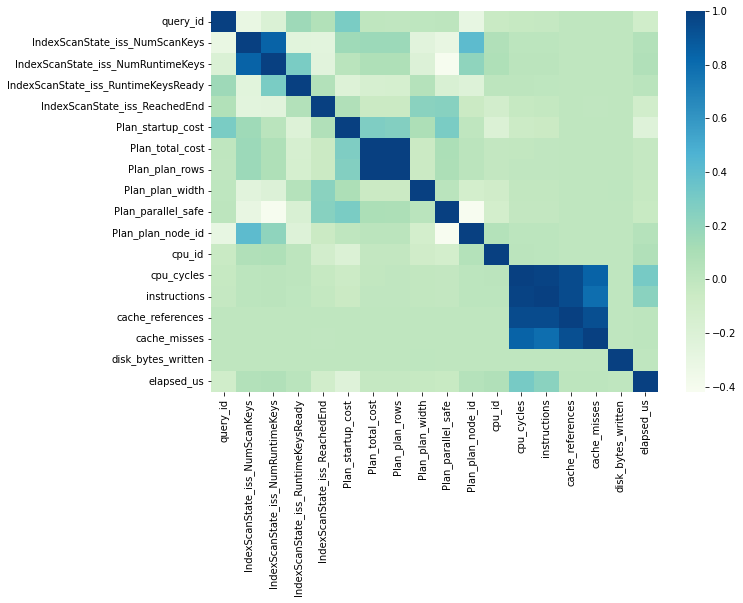

In [38]:
df_corr = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(df_corr, cmap='GnBu')
plt.show()

# Feature Analysis - PCA

In [40]:
def pca_summary(df):
    pca = PCA(n_components=None)
    pca.fit(df)
    print(f"Input Dimensionality: {len(df.columns)}")
    for component_idx, explained_var_pct in enumerate(pca.explained_variance_ratio_):
        print(f"Component {component_idx} explains {round(explained_var_pct*100, 2)}% of variance")

In [44]:
features.columns

Index(['IndexScanState_iss_NumScanKeys', 'IndexScanState_iss_NumRuntimeKeys',
       'IndexScanState_iss_RuntimeKeysReady', 'IndexScanState_iss_ReachedEnd',
       'Plan_startup_cost', 'Plan_total_cost', 'Plan_plan_rows',
       'Plan_plan_width', 'Plan_parallel_safe', 'Plan_plan_node_id'],
      dtype='object')

In [41]:
pca_summary(features)

Input Dimensionality: 10
Component 0 explains 99.95% of variance
Component 1 explains 0.05% of variance
Component 2 explains 0.0% of variance
Component 3 explains 0.0% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance
Component 6 explains 0.0% of variance
Component 7 explains 0.0% of variance
Component 8 explains 0.0% of variance
Component 9 explains 0.0% of variance


In [42]:
scanstate_feats = ['IndexScanState_iss_NumScanKeys', 'IndexScanState_iss_NumRuntimeKeys', 'IndexScanState_iss_RuntimeKeysReady']
pca_summary(features[scanstate_feats])

Input Dimensionality: 3
Component 0 explains 91.15% of variance
Component 1 explains 8.79% of variance
Component 2 explains 0.06% of variance


In [43]:
plancost_feats = ['Plan_startup_cost', 'Plan_total_cost']
pca_summary(features[plancost_feats])

Input Dimensionality: 2
Component 0 explains 99.98% of variance
Component 1 explains 0.02% of variance
